This notebook is a quick-and-dirty adaptation of a [TensorFlow Probability notebook for probabilistic PCA](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb), using the JAX library instead of Tensorflow.

In [123]:
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import jit, random, value_and_grad
from jax.experimental import optimizers
from jax.scipy.stats import multivariate_normal

plt.style.use("ggplot")

In [124]:
num_datapoints = 1000

data_dims = 2
latent_dims = 1

stddv_datapoints = 0.5

In [125]:
key = random.PRNGKey(1234)

In [126]:
def sample_from_model(key):
  key_w, key_z, key_x = random.split(key, num=3)

  W = 2.0 * random.normal(key_w, shape=(latent_dims, data_dims))
  z = random.normal(key_z, shape=(num_datapoints, latent_dims))
  x = actual_W * actual_z + random.normal(key_x, shape=(num_datapoints, data_dims))

  return W, z, x

key, key_sample = random.split(key)
actual_W, actual_z, x_train = sample_from_model(key_sample)

In [127]:
x_train.shape

(1000, 2)

(-7.0, 7.0, -7.0, 7.0)

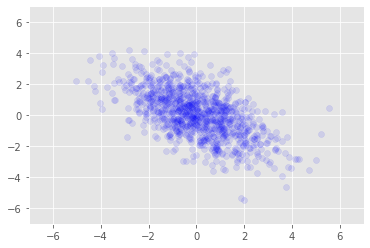

In [128]:
plt.scatter(x_train[:, 0], x_train[:, 1], color='blue', alpha=0.1)
plt.axis([-7, 7, -7, 7])

In [129]:
def llh(params, x_train):
  W, z = params
  return (
      multivariate_normal.logpdf(x_train, mean=W*z, cov=stddv_datapoints) + 
      multivariate_normal.logpdf(z, mean=jnp.zeros((num_datapoints, latent_dims)), cov=1) + 
      multivariate_normal.logpdf(W, mean=jnp.zeros((latent_dims, data_dims)), cov=1)
  ).sum()

llh([actual_W, actual_z], x_train)

DeviceArray(-48808.418, dtype=float32)

In [130]:
step_size = 1e-3

key, key_w, key_z = random.split(key, num=3)
params = [
  random.normal(key_w, shape=(latent_dims, data_dims)),
  random.normal(key_z, shape=(num_datapoints, latent_dims)),
]

opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

@jit
def update(i, opt_state):
  params = get_params(opt_state)
  value, grads = jax.value_and_grad(llh)(params, x_train)
  value = -value
  grads = [-g for g in grads]
  opt_state = opt_update(i, grads, opt_state)
  return value, opt_state

In [131]:
num_steps = 10_000

neg_llh = []
for i in range(num_steps):
  value, opt_state = update(i, opt_state)
  neg_llh.append(value)

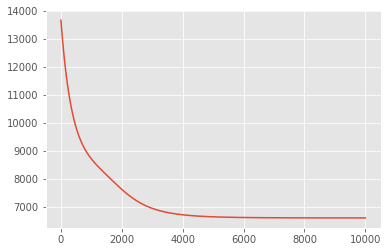

In [132]:
plt.plot(neg_llh)

In [133]:
W, z = get_params(opt_state)

In [135]:
key, key_x = random.split(key)
x_new = W * z + random.normal(key_x, shape=(num_datapoints, data_dims))

(-7.0, 7.0, -7.0, 7.0)

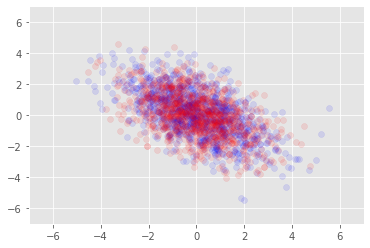

In [136]:
plt.scatter(x_train[:, 0], x_train[:, 1], color='blue', alpha=0.1)
plt.scatter(x_new[:, 0], x_new[:, 1], color='red', alpha=0.1)

plt.axis([-7, 7, -7, 7])